In [1]:
cd("/Users/michael/work/GitHub/epinets")

In [14]:
include("EpiSim.jl")

Main.EpiSim

In [3]:
using CSV
using Plots
using LightGraphs
using JLD2, FileIO
using Statistics

In [4]:
pops=[426709 8089526 245869 5095100 1751693 534281 6594804 2621680]
pop=pops[8]

2621680

In [7]:
#'reasonable' parameters
epiparam=Dict()
epiparam["p0"]=0.15 #a guess - tuned to match observed data 
epiparam["p2"]=0.15 #revised infection rate with distancing measure
epiparam["q"]=1/7 #"up to" two weeks
epiparam["r0"]=1/6 #about two weeks for mild, 3-6 for severe
epiparam["r2"]=1/6 #revised removal rate (now due to testing and isolation)
epiparam["nseeds"]=5 #probably too many, consider dropping.
#parameters don't change across transition point - assume about 5 undiagnosed case 
#and control the covidsafe uptake via network structure
i=8
epiparam["pop"]=Int(floor(sqrt(pops[i])))^2
epiparam["gridsize"]=Int(floor(sqrt(pops[i])))

1619

In [8]:
gridsize=epiparam["gridsize"]
bamodel=barabasi_albert(gridsize^2, 3, 2)
lattice=LightGraphs.grid((gridsize,gridsize),periodic=true)
#"social distancing"
wattstrog95=watts_strogatz(gridsize^2, 4, 0.013)  #s=0.013 => 95% compliance
wattstrog90=watts_strogatz(gridsize^2, 4, 0.026)  #s=0.026 => 90% compliance
wattstrog80=watts_strogatz(gridsize^2, 4, 0.053)  #s=0.053 => 80% compliance

{2621161, 5242322} undirected simple Int64 graph

In [21]:
#"covidsafe" at 40%
covidsafe=0.4
iso=covidsafe^2 #covidsafe implies removing iso fraction of all edges of graph
covidsafe40=deepcopy(wattstrog80) 
for edg in edges(covidsafe40)
    if rand(Float64) .< iso
        rem_edge!(covidsafe40,edg)
    end
end
#there are two parameters to play with here - the underlying model (here bamodel, but it could be an ER graph, or a truncated
#scale free network, or a lattice - wattsrog - with a certain fraction of remote links) The second parameter is the level of covidsafe adoption
# of course the original transmission parameters could be changed too....

In [19]:
St,Et,It,Rt=EpiSim.episim(covidsafe40, epiparam, 180, 20) #180 days, 100 simulations

100.0%┣██████████████████████████████████████████┫ 20/20 [05:48<00:00, 0.1 it/s]


(UInt64[0x000000000027fee4 0x000000000027fee4 … 0x000000000027fee4 0x000000000027fee4; 0x000000000027fee4 0x000000000027fee4 … 0x000000000027fee4 0x000000000027fee4; … ; 0x0000000000082f8e 0x0000000000083ded … 0x00000000000841be 0x0000000000083794; 0x0000000000082f79 0x0000000000083deb … 0x00000000000841b9 0x0000000000083782], UInt64[0x0000000000000005 0x0000000000000005 … 0x0000000000000004 0x0000000000000005; 0x0000000000000005 0x0000000000000005 … 0x0000000000000003 0x0000000000000004; … ; 0x00000000000000f7 0x0000000000000027 … 0x000000000000004b 0x0000000000000128; 0x00000000000000ec 0x0000000000000020 … 0x0000000000000046 0x000000000000010d], UInt64[0x0000000000000000 0x0000000000000000 … 0x0000000000000001 0x0000000000000000; 0x0000000000000000 0x0000000000000000 … 0x0000000000000002 0x0000000000000001; … ; 0x00000000000001c3 0x0000000000000061 … 0x0000000000000090 0x00000000000001c0; 0x000000000000019c 0x0000000000000051 … 0x0000000000000081 0x00000000000001a7], UInt64[0x000000

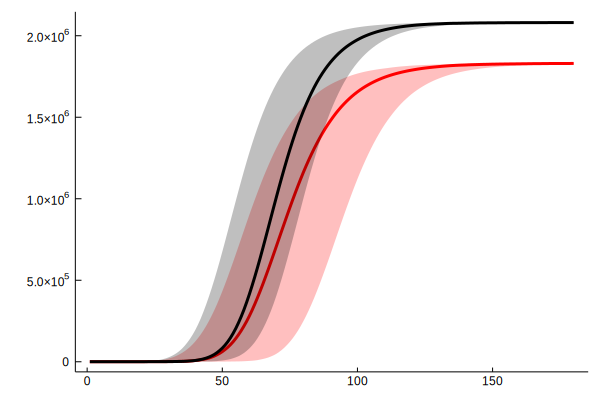

In [20]:
EpiSim.plotquantiles(pop .- St,:black)